<img src="image/hft_logo.jpg"
     alt="Hft Logo"
     align="right" 
     width="150" 
     height="150" />
# Mathematik Master Seminar
## Zeitreihenprognose mit Long short-term memory

---
### Philipp Dörich & Tim Oliver Walter
### 13. Dezember 2021

---

# Pakete laden

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use("fivethirtyeight")

# Datenimport

Bei dem Datensatz handelt es sich um Messwerte der Feinstaub-Konzentration in der Luft Mailands.

Die Daten wurden mit einem sogennanten "Laserstreuenden" Sensor abgetastet.

Der Datensatz enthält stündliche Mittelwerte der Messungen vom **24.07.2020 - 20.09.2020**.

In [2]:
df = pd.read_csv("data/aq_milan_summer_2020.csv")
df.head()

,local_datetime,pm2p5
0,2020-07-24 18:00:00,11.67
1,2020-07-24 19:00:00,9.25
2,2020-07-24 20:00:00,6.29
3,2020-07-24 21:00:00,5.50
4,2020-07-24 22:00:00,9.50


### Datenüberblick

In [3]:
print("Null values local_datetime:", df.isnull().sum()[0])
print("Null values pm2p5:", df.isnull().sum()[1])

Null values local_datetime: 0
Null values pm2p5: 0


In [4]:
stats = df.describe().transpose()
stats = stats.rename({"count":"rows"},axis=1)
stats

,rows,mean,std,min,25%,50%,75%,max
pm2p5,1398.0,12.668863,8.568262,1.0,6.0,10.225,17.9375,52.0


# Datensatz in Zeitreihe konvertieren

Eine Zeitreihe $y_t$ besteht aus endlich vielen, zeitlich angeordneten Messwerten:

&nbsp;&nbsp; $x_{t_1}, x_{t_2}, \ldots, x_{t_T}$ &nbsp;&nbsp; mit &nbsp;&nbsp; $x_{t_k} \in \mathbb{R}^n$ &nbsp;&nbsp; und &nbsp;&nbsp; $k = 1, 2, \ldots, T$.

Wobei gilt: &nbsp;&nbsp; $t_1 < t_2 < \ldots < t_T$. 

In [5]:
df = df.rename({
    "local_datetime":"ds",
    "pm2p5":"y"},
    axis=1)
df["ds"] = pd.to_datetime(df["ds"])
df = df.set_index("ds")
df.head()

,y
ds,
2020-07-24 18:00:00,11.67
2020-07-24 19:00:00,9.25
2020-07-24 20:00:00,6.29
2020-07-24 21:00:00,5.50
2020-07-24 22:00:00,9.50


 ### Beispiel multivariate Zeitreihe

Liegen zu jedem Zeitpunkt $n > 1$ Beobachtungen vor, spricht man von **multivariaten** Zeitreihen.

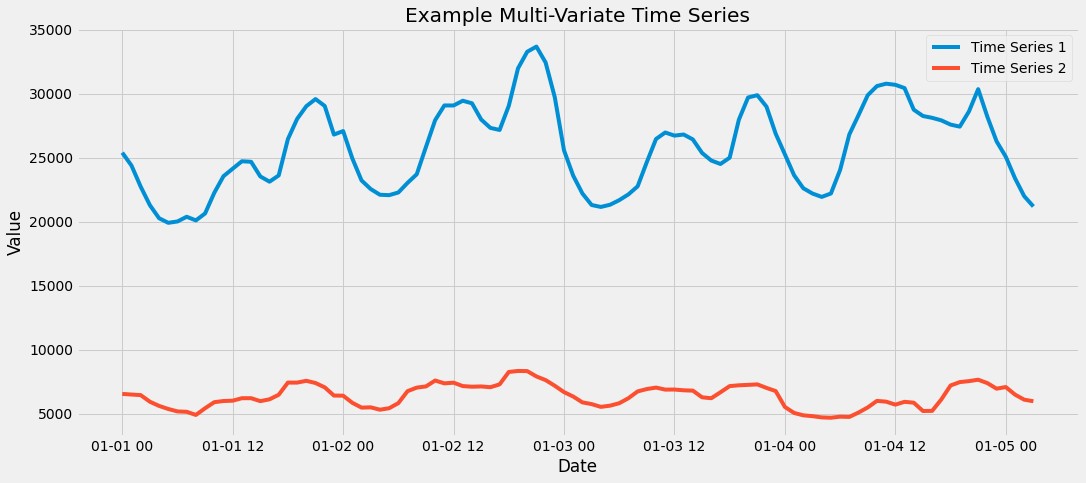

In [6]:
multi_df = pd.read_csv("data/multi.csv")
multi_df["time"] = pd.to_datetime(multi_df["time"])
multi_df = multi_df.set_index("time")
multi_df = multi_df.iloc[:100]

plt.figure(figsize=(16, 7))
plt.plot(multi_df)
plt.title("Example Multi-Variate Time Series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(["Time Series 1","Time Series 2"])
plt.show()

# Explorative Datenanalyse

### Visuellen Darstellung der univariaten Zeitreihe

Man nennt eine Zeitreihe **skalar** oder **univariat**, wenn $n = 1$ gilt, also zu jedem Zeitpunkt nur eine Beobachtung vorliegt.

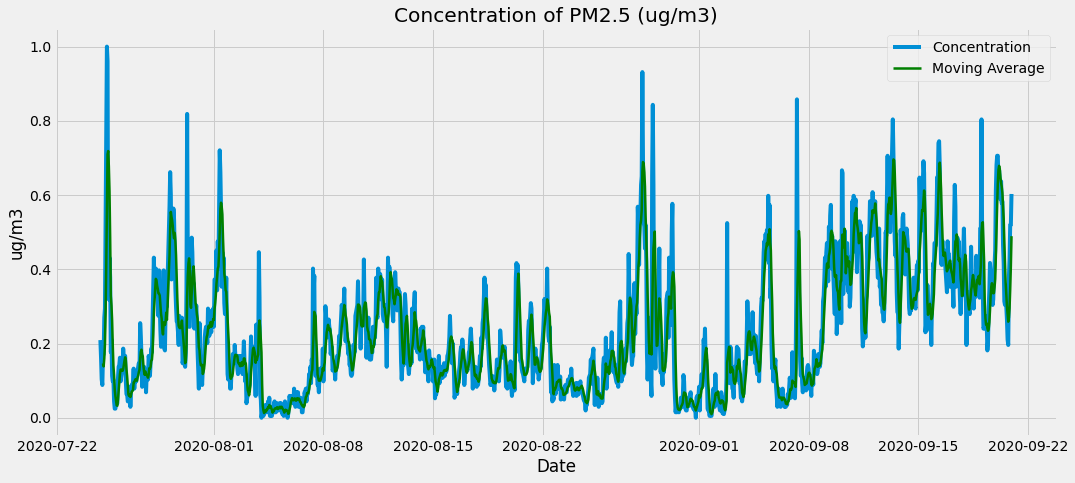

In [25]:
roll_mean = df.y.rolling(5).mean()
roll_std = df.y.rolling(5).std()

plt.figure(figsize=(16, 7))
plt.plot(df, label="Concentration")
plt.plot(roll_mean ,label="Moving Average",linewidth=2.5)
plt.xlabel("Date")
plt.ylabel("ug/m3")
plt.legend()
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()

### Ausreißeranalyse

Boxplots fassen die in einem Datenbestand enthaltenen Informationen mithilfe von **5** wichtigen Zahlen zusammen, der sogenannten Fünf-Punkte-Zusammenfassung einer Verteilung:

&nbsp;&nbsp; $x_{min} :=$ unterer Whisker

&nbsp;&nbsp; $x_{0.25} :=$ unteres Quantil

&nbsp;&nbsp; $x_{med} :=$ Median

&nbsp;&nbsp; $x_{0.75} :=$ oberes Quantil

&nbsp;&nbsp; $x_{max} :=$ oberer Whisker

![Boxplot](image/boxplot.jpg)

Die beiden Werte $x_{min}$ und $x_{max}$ informieren über den Datenausdehnungsbereich, ihre
Differenz ist die Spannweite $R$. Die linke und rechte Seite der Box, getrennt
durch die Linie des Medians, stellt jeweils 25% der Daten dar.

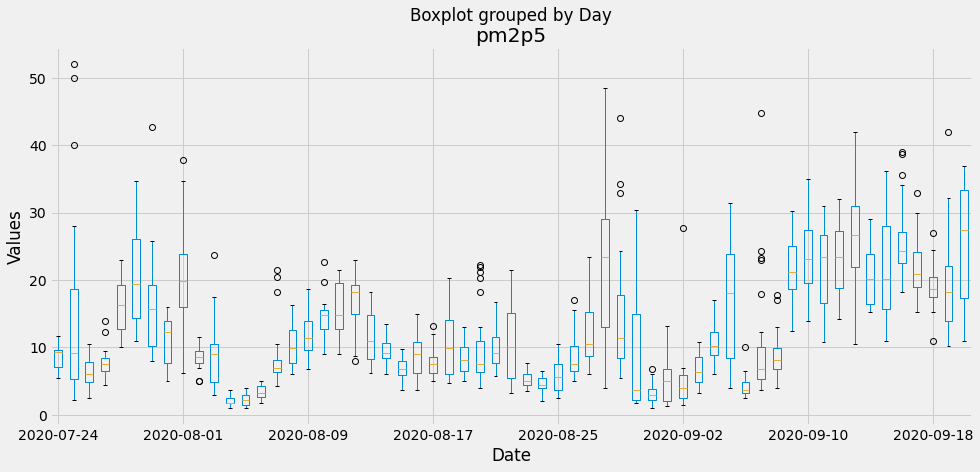

In [8]:
boxplot_df = df.copy()
boxplot_df["Day"] = boxplot_df.index.dayofyear
fig, ax = plt.subplots(figsize=(16, 7))
boxplot_df.boxplot(by ='Day', column =['y'], ax = ax)
ax.set_xticks(ax.get_xticks()[::8])
ax.set_xticklabels(boxplot_df.Day[::192].index.date)
plt.title("pm2p5")
plt.ylabel("Values")
plt.xlabel("Date")
plt.show()

### Häufigkeitsanalyse

Die Veranschaulichung der Häufigkeiten $h_j$ bzw. $f_j$ der Merkmalsausprägungen $x_j$ der
Klassen $j$ mit $j = 1, \ldots , M$ heißt Histogramm. Dazu werden Rechtecke über den Klassen

&nbsp;&nbsp; $[a_j ,b_j)$ mit $j = 1, \ldots, M$

mit einer Höhe proportional zu
&nbsp;&nbsp; $h^∗_j = \frac{h_j}{(b_j − a_j )}$ &nbsp;&nbsp; bzw. &nbsp;&nbsp; $f^∗_j = \frac{f_j}{(b_j − a_j )}$

gezeichnet. $f^*_j$ wird auch als Häufigkeitsdichte bezeichnet und gibt an, wie dicht die Beobachtungen im entsprechenden Intervall liegen.

![Histogramm](image/histogramm.jpg)

Die Abbildung zeigt den Zusammenhang zwischen der absoluten Häufigkeit $h_j$ und der Höhe $h^∗_j$ graphisch.

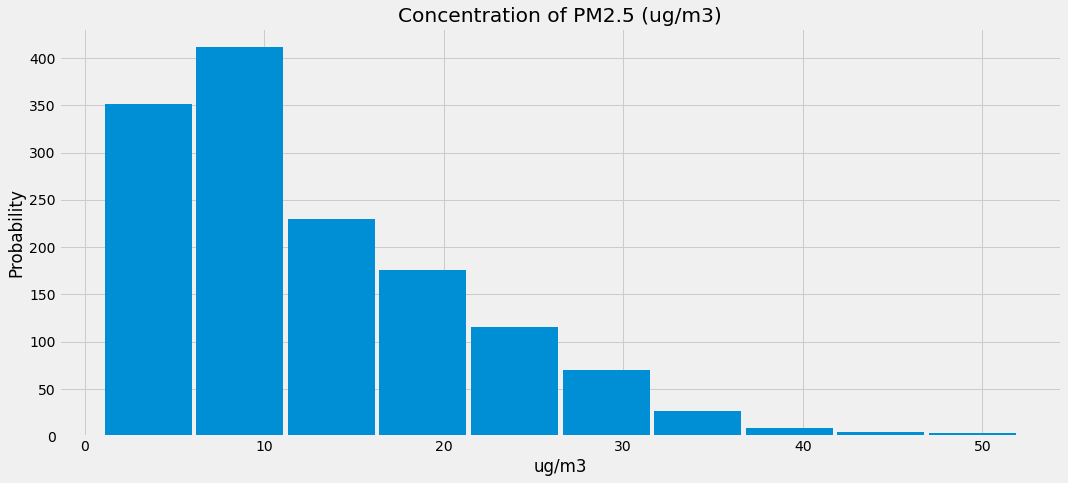

In [9]:
plt.figure(figsize=(16, 7))
plt.hist(df, rwidth = 0.95)
plt.xlabel("ug/m3")
plt.ylabel("Probability")
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()

### Zerlegung der Zeitreihe

Eine Zeitreihe $y_t$ lässt sich analog zu unserer obigen Definition, auf zwei Arten beschreiben:

Additiv: &nbsp;&nbsp; $y_t = S_t + T_t + R_t$

Multiplikativ: &nbsp;&nbsp; $y_t = S_t \cdot T_t \cdot R_t$

Dies ist von Vorteil, da in Zeitreihen oft mehrere Muster enthalten sind. Um diese Muster darstellen zu können wird die Zeitreihe in verschiedene Komponenten aufgeteilt. Die Komponenten sind wie folgt definiert:

$S_t :=$ Sesonalität

$T_t :=$ Trend

$R_t :=$ Rauschen

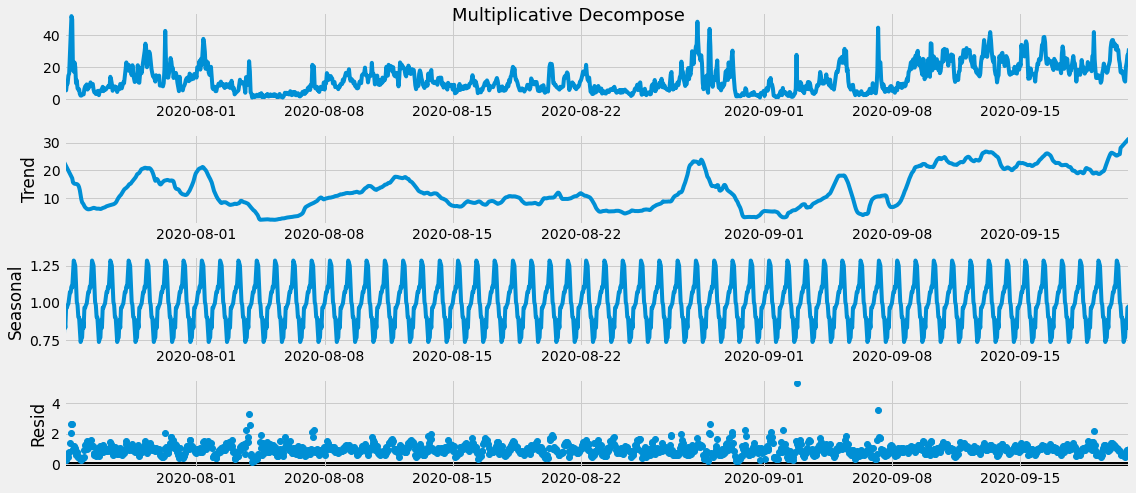

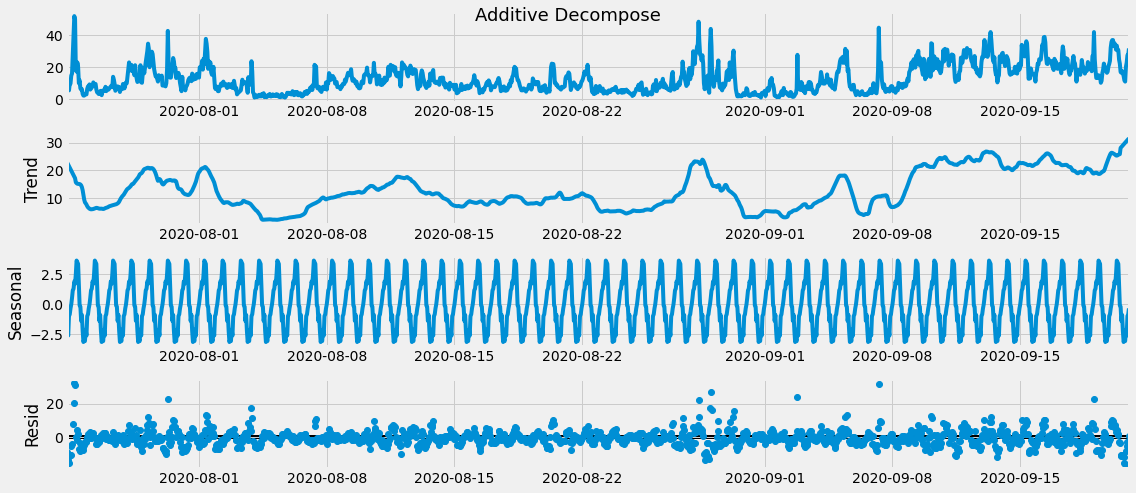

In [10]:
decompose_result_add = seasonal_decompose(df, model="additive", extrapolate_trend="freq")
decompose_result_mul = seasonal_decompose(df, model="multiplicative", extrapolate_trend="freq")

plt.rcParams.update({'figure.figsize': (16, 7)})
decompose_result_mul.plot().suptitle("Multiplicative Decompose", fontsize=18)
decompose_result_add.plot().suptitle("Additive Decompose", fontsize=18)
plt.show()

$\Rightarrow$ The additive decomposition, looks quite random. So ideally, additive decomposition should be preferred for this particular series.

### Korrelationsanalyse

**Autokerrelation (ACF)** misst den Zusammenhang zwischen den gemessenen Werten einer Zeitreihe, sie ist der *Korelationskoeffizient* zwischen zwei Zufallsvariablen $Y_t$ und $Y_{t + \tau}$. Hierbei beschreibt $\tau$ die Zeitdifferenz zwischen den beiden Zufallsvariablen. $\tau$ wird in diesem Zusammenhang auch als **Lag** bezeichnet.

Die ACF ist wie folgt definiert: &nbsp;&nbsp; $\rho(\tau) := \frac{Cov( Y_t, \; Y_{t + \tau})}{Var(Y_t)}$

Die **partielle Autokorrelation (PACF)** ist durch die ACF eindeutig bestimmt.

Mathematisch kann die PACF folgendermaßen beschrieben werden: $\pi(\tau) := \begin{cases}
        \Phi_{\tau, \tau} \;\;\;\;\;\;  \tau > 0\\
        1 \;\;\;\;\;\;\;\;\;\; \tau = 0\\
        \pi(-\tau) \;\;\;\; \tau < 0
    \end{cases}$
    
$\Phi_{\tau, \tau}$ beschreibt in der obigen Definition den Regressionskoeffizienten für den Regressionsansatz der Zufallsvariable $Y_{t + \tau}$.

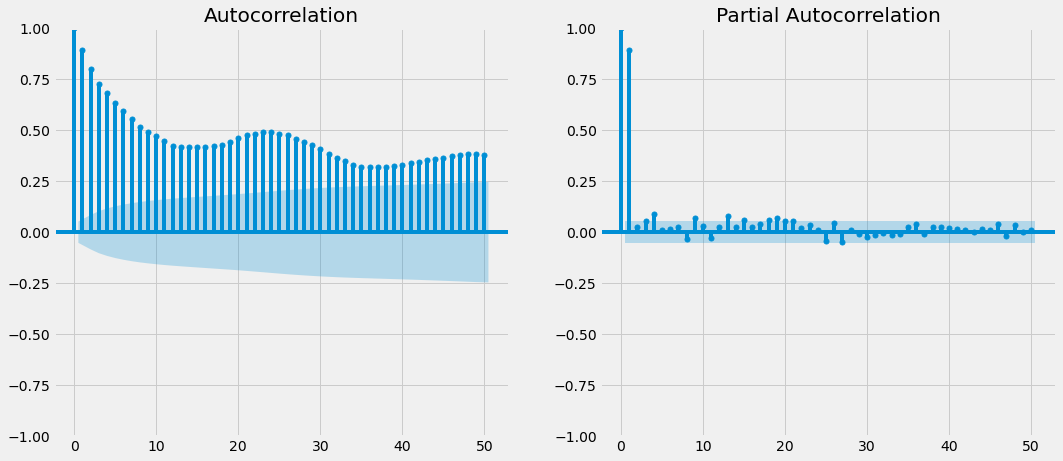

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 7))
plot_acf(df,lags=50, ax=ax1)
plot_pacf(df,lags=50, ax=ax2)
plt.show()

was sagen und die Plots aus? 
(Welle, blaue Schattierung)

### Test auf Stationarität

In [12]:
adf_result = adfuller(df)
print('ADF Statistic: %.3f' % adf_result[0])
print('p-value: %.3f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.749
p-value: 0.066
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


For this series, the p-value is very close to zero and much lower than the 3 confidence values mentioned. Therefore, we can reject the null hypothesis for this series. According to the ADF test, the time series of the concentration of particulate matter 2.5 in the air of Milan is therefore stationary.

# Neuronale Netze

### Rekurrente Neuronale Netze

Rekurrente Neuronale Netze **(RNN)** wurden entwickelt, um das "Gedächtnisproblem" bei Feedforward-Netzwerken zu lösen. RNN eignen sich somit vor allem für das Verarbeiten von sequenziellen Daten wie beispielsweise Zeitreihen. Eine Zelle eines RNN kann wie folgt visualisiert werden: 

![RNN-Zelle](image/rnnZelle.jpg)

Der Aktivierungsfunktion $\sigma_h$ wird zum Zeitpunkt $t$ die Eingabe $x_t$ und die vergangene Aktivierung $h_{t-1}$ übergeben. Mit Hilfe der Aktivierungsfunktion wird nun die Aktivierung $h_t$ berechnet. Mit der vorherigen Aktivierung $h_{t-1}$ wird nun die Ausgabe $y_t$ zum Zeitpunkt $t$ berechnet. 

### Skalierung der Zeitreihe

Neuronale Netze reagieren teilweise sehr empfindlich auf Ausreiser, dadurch kann es in manchen Fällen vorkommen, dass das Netz nicht das eigentlich zu lösende Problem erlernt. Daher werden, um den Lernprozess nicht unnötig zu verlangsamen, alle Daten auf das Intervall $[0, 1]$ skalliert, dadurch werden Ausreiser weniger stark gewichtet. 

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[["y"]] = scaler.fit_transform(df[["y"]])

### Aufteilen in Trainings- und Testmenge

In [14]:
y_train, y_test =train_test_split(df,shuffle=False, test_size=0.3)

print(f'Train: {y_train.shape}')
print(f'Test: {y_test.shape}')

Train: (978, 1)
Test: (420, 1)


### Sampling

In [15]:
def sampling(sequence, n_steps):
    X, Y = list(), list()
    for i in range(len(sequence)):
        sam = i + n_steps
        if sam > len(sequence)-1:
            break
            
        x, y = sequence[i:sam], sequence[sam]
        X.append(x)
        Y.append(y)
        
    return np.array(X), np.array(Y)

In [16]:
n_steps = 3
n_features = 1

X_train, Y_train = sampling(y_train["y"].tolist(), n_steps)

for i in range(5):
    #f'Train: {y_train.shape}'
    print(f'x = {X_train[i]}' + f'   ' + f'c = {round(Y_train[i], 8)}')
    print( )

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test, Y_test = sampling(y_test["y"].tolist(), n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

x = [0.20921569 0.16176471 0.10372549]   c = 0.08823529

x = [0.16176471 0.10372549 0.08823529]   c = 0.16666667

x = [0.10372549 0.08823529 0.16666667]   c = 0.17156863

x = [0.08823529 0.16666667 0.17156863]   c = 0.26960784

x = [0.16666667 0.17156863 0.26960784]   c = 0.29411765



### Long short-term memory

![lstmZelle](image/lstmZelle.jpg)

**Long Short-Term Memory-Netzwerke (LSTM)** sind RNN. Im Gegensatz zu ursprünglichen RNN-Zellen erhalten die LSTM-Zellen, neben der Eingabe $x_t$ und der Aktivierung aus dem vorherigen Zeitschritt $h_{t-1}$, auch den Zellzustand $c_{t-1}$, der als Gedächtnis der Einheit fungiert.

***TODO***

### Entwickeln eines LSTM-Modells

In [17]:
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train, Y_train,validation_data=(X_test, Y_test),epochs=8, batch_size=50,verbose=1)

Epoch 1/8
20/20 [==============================] - 1s 10ms/step - loss: 0.0310 - val_loss: 0.0638
Epoch 2/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0262
Epoch 3/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0206
Epoch 4/8
20/20 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0152
Epoch 5/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0123
Epoch 6/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0103
Epoch 7/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0101
Epoch 8/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0099


### Validierung des Modells

***TODO:*** Was bedeutet Loss-Function?

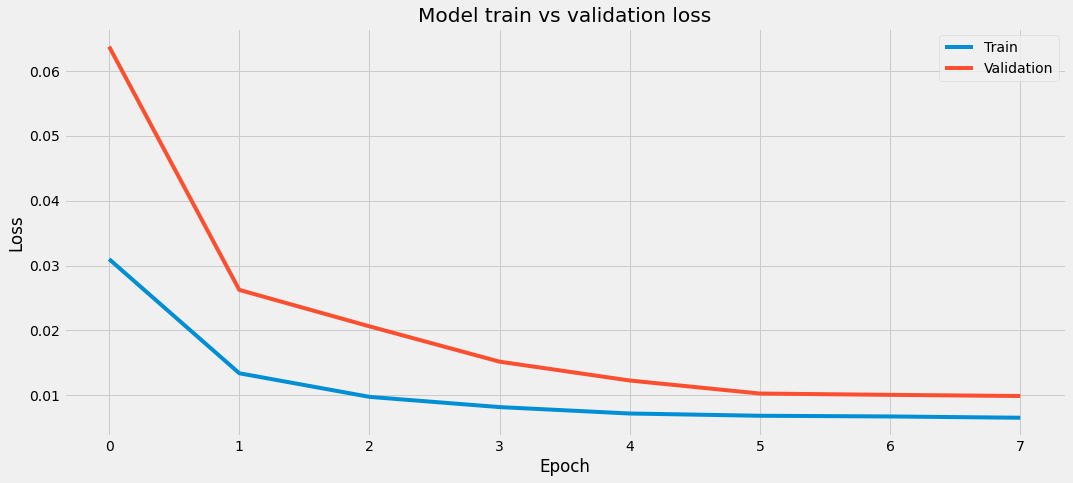

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model train vs validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])
plt.show()

In [20]:
y_train = y_train.iloc[n_steps:,:]
y_test = y_test.iloc[n_steps:,:]

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

y_train["pred_train"] = pd.Series(train_pred.flatten(), index=y_train.index)
y_test["pred_test"] = pd.Series(test_pred.flatten(), index=y_test.index)

Die **mittlere quadratische Abweichung (mean squared error - MSE)** ist ein häufig verwendetes Maß zur Fehlerabschätzung bei Prognose-Algorithmen für Zeitreihen. Der MSE kann mathematisch wie folgt definiert werden:

&nbsp;&nbsp; $MSE(y_t, y_t^*) := \frac{1}{n} \sum_{i = 0}^{n - 1} ({y_t}_i - {y_t^*}_i)^2$

Die **Wurzel der mittleren quadratischen Abweichung (root mean squared error - RMSE)** ist definiert als: 

&nbsp;&nbsp; $RMSE(y_t, y_t^*) := \sqrt{MSE(y_t, y_t^*)}$



In [21]:
train_score = mean_squared_error(y_train.y,y_train.pred_train)
print('Train Score: %.4f MSE' % (train_score))
print('Train Score: %.4f RMSE' % (np.sqrt(train_score)))

test_score = mean_squared_error(y_test.y,y_test.pred_test)
print('Test Score: %.4f MSE' % (test_score))
print('Test Score: %.4f RMSE' % (np.sqrt(test_score)))

Train Score: 0.0064 MSE
Train Score: 0.0802 RMSE
Test Score: 0.0099 MSE
Test Score: 0.0994 RMSE


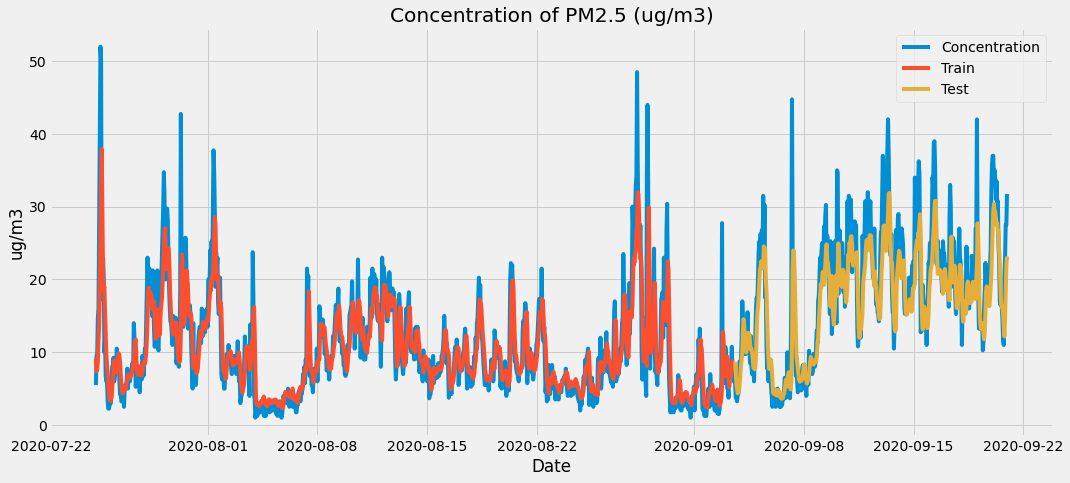

In [22]:
result= pd.concat([y_train,y_test])
result[["y","pred_train","pred_test"]] = scaler.inverse_transform(result[["y","pred_train","pred_test"]])

plt.plot(result.y,label="Concentration")
plt.plot(result.pred_train, label="Train")
plt.plot(result.pred_test, label="Test")
plt.xlabel("Date")
plt.ylabel("ug/m3")
plt.legend()
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()

The model looks good now let's make a forecast!

# Vorhersage

In [23]:
pred = model.predict(X_test[-24:])
index=pd.date_range(start="2020-09-20 23:00:00", periods=24, freq="H")
pred_df = pd.DataFrame(pred.flatten(), index=index, columns=["pred"])

result= pd.concat([result,pred_df])
result[["pred"]] = scaler.inverse_transform(result[["pred"]])

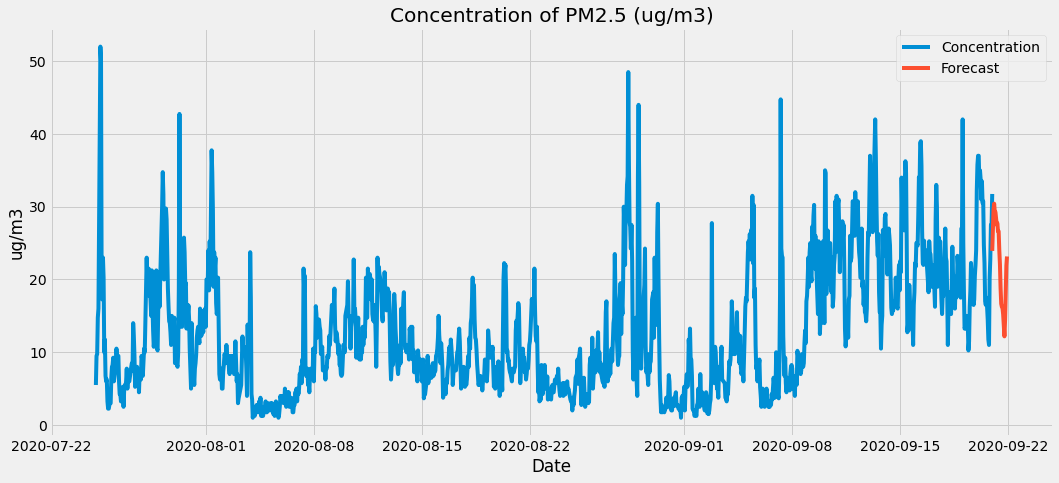

In [24]:
forecast = result[["y","pred"]]

plt.plot(forecast.y, label="Concentration")
plt.plot(forecast.pred ,label="Forecast")
plt.xlabel("Date")
plt.ylabel("ug/m3")
plt.legend()
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()